# Learning Activity - Backpropagation
Goal - Build the components to train an neural network to solve the XOR problem.  Train the ANN and examine the results

In this exercise, we implement Goodfellow's Algorithm 6.4: Backpropagation.  Most of the code is provided

Students will need to code scections defining the derivatives of the activation functions (ReLu, Sigmoid) in STEP 1, and the loss functions (Mean Squared Error, Binary Cross Entropy) in STEP 2  (the code will not work until you do these things)

Near the end of the notebook is the (provided) code to build and train a model to solve XOR (STEP 3).   It is recommended to rerun the training process several times, trying out different hyperparameters.

In [1]:
import os
import numpy as np
import copy
import matplotlib.pyplot as plt

## STEP 1: Student Coding for activation function derivatives

Helper Functions - Activations and derivatives

Students should review the activation functions, then Code the sigmoid derivative and Relu derivative in the code cell below:

```def dSigmoid(x):  # derivative of sigmoid```

```def dRelu(z):```

In [2]:
def sigmoid(x):
    """numpy array-compatible sigmoid (logistic) function"""
    return 1. / (1. + np.exp(-x))


def dSigmoid(x):  # derivative of sigmoid
    """a function which returns derivative of sigmoid"""
    ds = None #placeholder

    # in the student code area below,
    # compute the derivative of the sigmoid function
    # USE NUMPY (np) to make sure this operation is array-compatible
    # Hint:  the derivative of a sigmoid can also be written as a function of a sigmoid

    #######################     STUDENT CODE      ###################################
 
    ds = sigmoid(x)*(1-sigmoid(x))

    ####################     END STUDENT CODE      ##################################
    
    return ds


def relu(z):  # rectified linear unit activation
    """numpy array-compatible ReLU function"""
    return np.maximum(0, z)


def dRelu(z):
    """ 
    A function which returns the derivative of Rectified Linear Unit

    """
    dr = None #placeholder
    
    # in the student code area below,
    # compute the derivative of the ReLU function
    # USE NUMPY (np) to make sure this operation is array-compatible
    # recall that the derivative of a ReLU is not continuous (it has 2 possible values)
    # Challenge:  Write this without an if statement
    # Hint:  Use logic; in python, multiplying True by a scalar value yields the scalar and
    #        multiplying False by a scalar value yields zero
    
    #######################     STUDENT CODE      ###################################
    # compute the derivative of the ReLU function
    dr = 1.0*( z > 0)
    
    ####################     END STUDENT CODE      ##################################

    return dr


## STEP 2: Student Coding:

You will need to code Mean Squared Error (MSE) and Binary Cross Entropy (BCE) loss functions.  Later the loss function will be selected as part of the ANN class instatiation

Note that only BCE is appropriate for binary classification, but if you switch to a regression problem you should use MSE for the loss function



In [3]:
def compute_mse_loss(raw_outputs, desired_targets):
    """computes the (scalar) loss using MSE of a set of desired targets and raw_outputs 
    desired_targets is assumed to be a matrix of shape [samples, 1]"""

    # note that the loss function MSE is on the RAW activation outputs
    #  it is not the MSE on the thresholded outputs

    mse = None #placeholder - add code below to compute the MSE loss

    # Complete the MSE loss computation below

    #######################     STUDENT CODE      ###################################

    np.sum((raw_outputs - desired_targets)**2)/raw_outputs.size

    #####################     END STUDENT CODE   ####################################

    return mse


def compute_bce_loss(raw_outputs, desired_targets):
    """computes the (scalar) loss using binary cross entopy of a set of desired targets and raw_outputs
     desired_targets is assumed to be a matrix of shape [samples, 1]"""

    # note that the loss function Binary Cross Entropy (BCE) on the RAW activation outputs
    # ... it is NOT the BCE on the thresholded outputs

    bce = None #placeholder - add code below to compute the BCE loss

    # Complete the BCE loss computation below
    #  Hint:  See https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/binary-crossentropy

    #######################     STUDENT CODE      ###################################

    bce = -np.mean(desired_targets*np.log(raw_outputs)+(1-desired_targets)*np.log(1-raw_outputs))

    #####################     END STUDENT CODE   ####################################

    return bce

ANN Class definition includes the following function (near the bottom of the cell)

```    def compute_loss(self, inputs, desired_targets): ```


In [4]:
class ANN:
    data = []
    layers = []  #each network can have multiple layers
    inputWidth = 1
    outputWidth = 1
    loss_function = []

    # LAYER CLASS
    class Layer:

        """class defining the elements of an ANN layer"""

        def __init__(self):
            self.w = []
            self.b = []
            self.nodecount = []
            self.activation_fcn = []
            self.activation_fcn_derivative = []
            self.orderNumber = []
            self.previous = None  # link to previous layer
            self.next = None  # link to next layer

        def set_weights(self, w, b):
            """set the weights and bias for the layer.  Layer weights should have dimesion: (thislayer_nodecount, previouslayer_nodecount)
            the dimension of the bias should be (thislayer_nodecount,1)"""
            self.w = w
            self.b = b
            return self

        def initialize_weights(self):
            assert self.w != []
            assert self.b != []
            self.b = np.random.normal(size=(self.w.shape))  # hidden weight matrix [rows = to, columns = from]
            self.w = np.random.normal(size=(self.b.shape))  # hidden biases (column vector)

        def set_activation(self, activation_fcn):
            """Sets the activation function for the entire layer (each layer can have its own activation)"""
            self.activation_fcn = activation_fcn
            return self

        def set_activation_deriv(self, activation_fcn):
            """Sets the activation function for the entire layer (each layer can have its own activation)
            In python, pass the function with its name only - dont include the parentheses"""
            if activation_fcn == sigmoid:
                self.activation_fcn_derivative = copy.deepcopy(dSigmoid)
            elif activation_fcn == relu:
                self.activation_fcn_derivative = copy.deepcopy(dRelu)
            else:
                self.activation_fcn_derivative = None

        def compute_pre_activation(self, inputs):
            """Computes the results of the sum of the weights by the inputs and adds the bias"""
            net = np.dot(self.w, inputs) + self.b
            return net

        def compute_bias_gradient(self, gradient):
            """Computes the gradient for the bias"""
            gb = np.mean(gradient, axis=1)[:, np.newaxis]  # no regularization
            return gb

        def compute_weight_gradient(self, inputs, gradient):
            """Computes the gradient for the weigts at the current input value for this layer"""
            gw = np.dot(gradient, inputs.T)
            return gw

        def compute_activation(self, net):
            return self.activation_fcn(net)

        def compute_activation_derivative(self, net):
            return self.activation_fcn_derivative(net)

        def compute_activation_gradient(self, net, gradient):
            """Computes the gradient for the activation function at the current net value for this layer"""
            ga = np.multiply(gradient, net)  # Hadamard (elementwise) product
            return ga

        def compute_forward(self, inputs):
            """Returns layer ouput from input (shape = [nodeCount, input]) of the weighted input plus bias
            input shape must be [lastlayer_nodeCount, samples] or [featurecount, samplecount] """
            net = self.compute_pre_activation(self, inputs)
            layer_out = self.compute_activation(net)
            return layer_out

        def compute_layer_gradients(self, inputs, net, activation, gradient):
            """ computes the loss gradient with respect to desired output of the layer
            a set of desired targets is assumed to be matrix of shape [nodecount, samples]: SGD will have [nodecount,1]
            hidden_inputs is assumed to be a matrix of shape [hiddenNodeCount, samples]
            returns 
                g_loss:  the gradient of current layer
                g_loss_b:  the gradient of the bias (for update purposes)
                    Note:  we dont need to pass the g_loss_w gradient of the weights, but it is computed here
                g_loss_backprop: the gradient 
            
            
            This follows algorithm 6.4 for the current layer starting inside the For loop
            
            """
            
            # f'(a(k))
            d_activation = self.compute_activation_derivative(net)  # derivative of activation:  shape = [NodeCount, samples]
            
            # g <- g * f'(a(k))
            g_loss = self.compute_activation_gradient(d_activation, gradient)  # shape = [NodeCount, samples]  [1, _ ] for outer layer
            
            # Delta_b(k) J = g (Take the mean across all 4 samples (batch))
            g_loss_b = self.compute_bias_gradient(g_loss)  # mean gradient with respect to BIAS, shape = [NodeCount, 1]
            
            # Delta w(k) J = g * h(k-1)
            g_loss_w = self.compute_weight_gradient(activation, g_loss)  # [1, 3]  Hidden layer outputs after activation
            
            # Determine gradient for the previous layer to pass backwards
            # g <- W(k).T * g
            g_loss_backprop = np.dot(self.w.T, g_loss)  # gradient to propagate back, shape = [hiddenNodeCount,samples]
            
            return g_loss_w, g_loss_b, g_loss_backprop

        def update_Layer(self, weightUpdate, biasUpdate):
            self.w = self.w + weightUpdate
            self.b = self.b + biasUpdate
            
            
    # ANN MODEL CLASS DEFINITIONS
    def __init__(self):
        self.data = []
        self.layers = []
        self.inputWidth = 1
        self.outputWidth = 1
        self.loss_function = []


    def set_input_width(self, inputWidth):
        """defines the input layer width for the network"""
        self.inputWidth = inputWidth

    def add_layer(self, nodecount=1, activation_fcn=relu):
        """adds a layer to the neural network and returns the layer
        Defaults with 1 node using relu activation"""
        
        oldLayerCount = len(self.layers)
        thislayer = ANN.Layer()
        thislayer.orderNumber = oldLayerCount + 1
        if oldLayerCount > 0:  # other layers have been added already
            lastLayer = self.layers[-1]
            thislayer.previous = lastLayer
            lastLayer.next = thislayer
            layerInputSize = lastLayer.w.shape[1]

        else:  # this will be the first layer
            layerInputSize = self.inputWidth
        thislayer.w = np.zeros((layerInputSize, nodecount))
        thislayer.b = np.zeros((1, nodecount))
        thislayer.activation_fcn = activation_fcn
        thislayer.set_activation_deriv(activation_fcn)
        self.layers = self.layers + [thislayer]
        return thislayer

    def set_loss_function (self, loss_function):
        """Sets the loss function for the entire network 
        In python, pass the function with its name only - dont include the parentheses"""
        self.loss_function = copy.deepcopy(loss_function)

    
    def forwardPropagation(self, inputs):
        """Compute forward pass of two layer network
        inputs are assumed to be (shape=[sampleCount,featureCount])
        returns a matrix of raw outputs with one row of output per node (shape=[sampleCount, outputNodeCount])
        Internal matrices are shaped for efficiency to avoid internal transposes (columns hold observations/samples) """

        # inputs and outputs will be transposed for efficiency during forwardPropagation and untransposed before returning

        nets = []
        activations = []
        layer_input = inputs.T

        for lnum, layer in enumerate(self.layers):
            # inputs = inputs + inputs
            layer_net = layer.compute_pre_activation(layer_input)
            nets.append(layer_net)

            layer_out = layer.compute_activation(layer_net)
            activations.append(layer_out)

            layer_input = layer_out
        raw_output = layer_out.T
        return raw_output, inputs, nets, activations

    def backPropagation(self, inputs, desiredOutputs, learningRate):
        w_grads = []
        b_grads = []
        # store nets and activations for each layer
        raw_output, _, nets, activations = self.forwardPropagation(inputs)
        layer_desired_out = desiredOutputs

        # Note: This is only part of the gradient represented by the derivative of the binary cross entropy
        # function with respects to the inputs of the logistic function at the output layer
        #  See https://peterroelants.github.io/posts/cross-entropy-logistic/ for details
        layer_grad = desiredOutputs - raw_output

        #  computation of full gradient handled inside the loop below
        for lnum, layer in reversed(list(enumerate(self.layers))):
            if lnum == 0:
                prev_layer_output = inputs.T
            else:
                prev_layer_output = activations[lnum - 1]
            if lnum == len(self.layers)-1:  #OUTPUT LAYER
                w_grad, b_grad, loss_grad = layer.compute_layer_gradients(prev_layer_output, nets[lnum], prev_layer_output,
                                                                          layer_grad.T)
            else:
                w_grad, b_grad, loss_grad = layer.compute_layer_gradients(prev_layer_output, nets[lnum], prev_layer_output,
                                                                          layer_grad)
            layer.update_Layer(w_grad * learningRate, b_grad * learningRate)
            layer_grad = loss_grad

    def predict(self, X, threshold=0.5):
        """Compute predictions using forward propagation for single binary classification at threshold
        X is a standard dataFrame without biases (shape=[observationCount,featureCount])
        returns a standard column vector of binary predictions in {0,1}: (shape=[observationCount, 1])"""
        raw_predictions, net_inputs, net_lst, activation_lst = self.forwardPropagation(X)
        preds = raw_predictions > threshold
        return preds

    def compute_loss(self, inputs, desired_targets):
        return self.loss_function(inputs, desired_targets)
    
    
    def fit(self, inputs, desired_targets, learningRate, learningRateDecay, tolerance=1e-2, max_epochs = 1000):
        done = False
        loss_history = []
        print("Training Model...")
        epoch_counter = 1
        while not done:
            learningRate = learningRate * learningRateDecay
            preds = self.predict(inputs)
            correct = desired_targets == preds
            raw_outputs = self.forwardPropagation(inputs)[0]
            curr_loss = self.compute_loss(raw_outputs, desired_targets).item()
            loss_history.append(curr_loss)
            if curr_loss < tolerance:
                done = True
            if epoch_counter > max_epochs:
                done = True
            # run an epoch of backprop
            self.backPropagation(inputs, desired_targets, learningRate=learningRate)
            epoch_counter+=1
        print("Training Complete!")

        return loss_history

### Helper function for decision boundary based on threshold exceeding cutoff

In [5]:
def makeDecisionBoundaryBool2(model, featureData, labelData, title, threshold = 0.5):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''
    cutoff = threshold  # Use 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = model.predict(grid)  # get predictions
    z = preds.reshape(X.shape) > cutoff  # cutoff on predictions to return boolean output
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()


def show2dFunctionOutput(model_function, featureData, labelData, title):
    """display RAW results of arbitrary model function on 2-input (x1,x2) , 1-output (z) graphs"""
    # cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    outputs, _, _, _ = model_function(grid)  # get predictions
    z = outputs.reshape(X.shape)  # reshape predictions for 2d representation
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()

### Helper function for getting Boolean logic datasets

In [6]:
def get_input_output_data(gate='XOR'):
    """ Two dimensional inputs for logic gates

    Parameters
    ----------
    gate : str
        Must be one of these {'AND', 'OR', 'XOR'}

    Returns
    -------
    X : array-like, shape(samples, features)
        Two dim input for logic gates

    truth[gate] : array-like, shapes(samples, )
        The truth value for this logic gate

    """

    X = np.array([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

    truth = {
        'AND': np.array([0, 0, 0, 1]),
        'OR': np.array([0, 1, 1, 1]),
        'XOR': np.array([0, 1, 1, 0])
    }

    return X, truth[gate][:, np.newaxis]

### Helper function for instantiating, training and evaluating an ANN

In [7]:
def train_ANN_model(hidden_nodes=3,
                    learning_rate=1.0,
                    lr_decay=0.999,
                    hidden_act=sigmoid,
                    output_act=sigmoid,
                    output_loss_fcn = compute_bce_loss,
                    gate_type='XOR',
                    max_epochs = 1000):
    
    X, Y = get_input_output_data(gate=gate_type)

    model = ANN()
    model.set_input_width(X.shape[1])
    model.set_loss_function(output_loss_fcn)
    
    l1_weights = np.random.rand(hidden_nodes, 2)
    l1_bias = np.random.rand(hidden_nodes, 1)
    l2_weights = np.random.rand(1, hidden_nodes)
    l2_bias = np.random.rand(1, 1)

    layer1 = model.add_layer(nodecount=hidden_nodes, activation_fcn=hidden_act)
    layer1.set_weights(l1_weights, l1_bias)
    layer2 = model.add_layer(nodecount=1, activation_fcn=output_act)
    layer2.set_weights(l2_weights, l2_bias)

    preds = model.predict(X)
    correct = Y == preds

    print()
    print("predictions: \n", preds)
    print("Predictions correct?: \n", correct)

    loss_history = model.fit(inputs=X, desired_targets=Y, learningRate=learning_rate, learningRateDecay=lr_decay,
                             tolerance=1e-10, max_epochs=max_epochs)

    preds = model.predict(X)
    correct = Y == preds
    
    print()
    print("predictions: \n", preds)
    print("Predictions correct?: \n", correct)

    show2dFunctionOutput(model.forwardPropagation, X, Y, "Raw Response of Network - student")
    if output_act == sigmoid:
        threshold = 0.5 # 0.5 for sigmoid
    makeDecisionBoundaryBool2(model, X, Y, "Thresholded XOR predictions - student", threshold) 

    plt.figure()
    plt.plot(loss_history)
    plt.xlabel("iteration")
    plt.ylabel("Loss (BCE)")
    plt.title("Loss over iterations (epochs)")
    plt.show()

## STEP 3:  Instantiate / Train / Eval model on XOR

Now see if you can get it to work... note that since the weights and biases are initialized randomly you may need to run this several times.
Also, you can try different settings to solve XOR:
* You can try different quantities of ```hidden_nodes```; at least 2 are needed, but more nodes will likely make training more successful
* ```learning_rate``` can be altered from ```1.0``` and be decayed using a value other than the default (```lr_decay=0.9999```).  The closer the ```lr_decay``` is to 1, the slower the decay, and setting ```lr_decay``` to ```1.0``` would mean having no decay.  If your small network is having trouble learning you may need to reduce the learning rate.   A slow learning rate might require a higher ```max_epochs```.
* You can change the hidden layer activation to either "```relu```" or "```sigmoid```, but a sigmoid hidden layer might be easier to train in a small node-count layer since relus could *die* if they output zero for every observation; if you want to try relu you might want to increase ```hidden_nodes``` count  (see https://towardsdatascience.com/the-dying-relu-problem-clearly-explained-42d0c54e0d24https://towardsdatascience.com/the-dying-relu-problem-clearly-explained-42d0c54e0d24)
* Keep the output activation (```output_act```) as sigmoid
* Keep the ```output_loss_fcn``` as ```compute_bce_loss```


Hint... if you are struggling getting this to solve XOR, try the suggestions in the markdown cell at the end of this jupyter notebook



predictions: 
 [[ True]
 [ True]
 [ True]
 [ True]]
Predictions correct?: 
 [[False]
 [ True]
 [ True]
 [False]]
Training Model...
Training Complete!

predictions: 
 [[False]
 [ True]
 [ True]
 [False]]
Predictions correct?: 
 [[ True]
 [ True]
 [ True]
 [ True]]


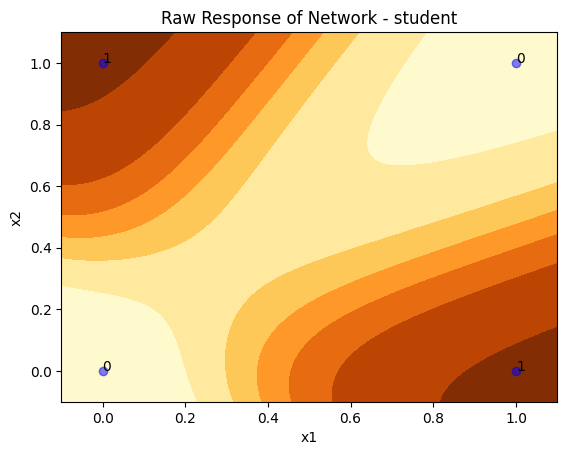

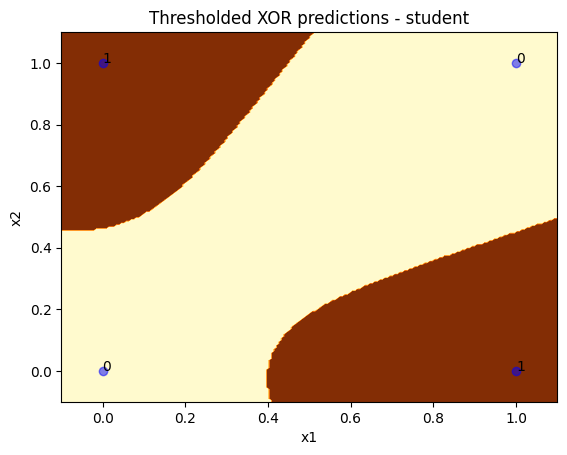

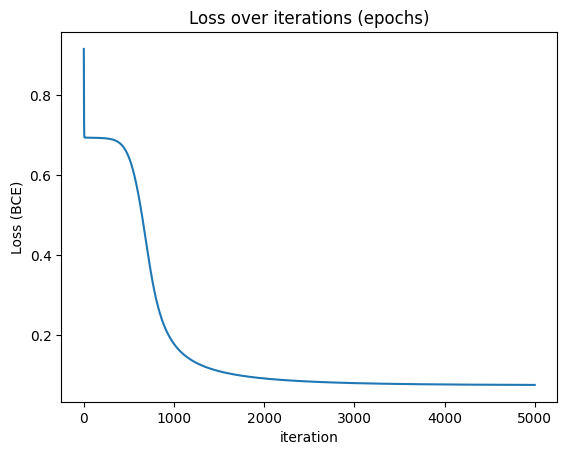

In [22]:
train_ANN_model(hidden_nodes=3,
                   learning_rate=1.0,
                   #lr_decay=0.9999,
                   hidden_act=sigmoid,  #relu or sigmoid
                   output_act=sigmoid,
                   output_loss_fcn = compute_bce_loss,
                   gate_type='XOR',
                   max_epochs = 5000)


### Example with Sigmoid for the hidden layer
```
train_ANN_model(hidden_nodes=3,
                   learning_rate=1.0,
                   lr_decay=0.9999,
                   hidden_act=sigmoid,  #relu or sigmoid
                   output_act=sigmoid,
                   output_loss_fcn = compute_bce_loss,
                   gate_type='XOR',
                   max_epochs = 5000)
```

### Example with ReLU for the hidden layer.  Note the large number of hidden nodes
```
train_ANN_model(hidden_nodes=20,
                   learning_rate=1.0,
                   lr_decay=0.9999,
                   hidden_act=relu,  #relu or sigmoid
                   output_act=sigmoid,
                   output_loss_fcn = compute_bce_loss,
                   gate_type='XOR',
                   max_epochs = 5000)
```
